In [1]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
import torch.nn.functional as F


In [2]:
network_config = {}
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# implement a basic tokenizer from scratch (Anderj Karpathy's tutorial)
class BasicTokenizer:
    def __init__(self, vocab_size=300):
        self.vocab = {}
        self.merges = {}
        self.vocab_size = vocab_size
        # self.ids = []
    def train(self, text, verbose=False):
        tokens = self.read_file(text)
        num_merge = self.vocab_size - 256
        ids = tokens.copy()
        for i in range(num_merge):
            num_merge = 256 + i
            stats = self.get_stats(ids)
            top_pair = self.get_top_pair(stats)
            if verbose:
                print(f"merging {top_pair} into {num_merge}")
            ids = self.merge(ids, top_pair, num_merge)
            self.merges[top_pair] = num_merge
        self.vocab = {idx: bytes([idx]) for idx in range(256)}
        for (p1, p2), idx in self.merges.items():
            self.vocab[idx] = self.vocab[p1] + self.vocab[p2]
        # self.ids = ids
        return ids
    
    def read_file(self, text):
        tokens = text.encode("utf-8")
        tokens = list(map(int, tokens))
        return tokens
    def get_stats(self, tokens):
        maps = {}
        for p1, p2 in zip(tokens, tokens[1:]):
            maps[(p1, p2)] = maps.get((p1, p2), 0) + 1
        return maps
    def get_top_pair(self, maps):
        top_pair = max(maps, key=maps.get)
        # self.merges.append(top_pair)
        return top_pair
    def merge(self, ids, top_pair, idx):
        res = []
        i = 0
        p1, p2 = top_pair
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == p1 and ids[i+1] == p2:
                self.merges[top_pair] = idx
                res.append(idx)
                i += 2
            else:
                res.append(ids[i])
                i += 1
        return res
    def encode(self, text):
        tokens = self.read_file(text)
        ids = tokens.copy()
        i = 0
        res = []
        while i < len(ids):
            if i < len(ids) - 1 and (ids[i], ids[i+1]) in self.merges:
                res.append(self.merges[(ids[i], ids[i+1])])
                i+=2
            else:
                res.append(ids[i])
                i+=1
        return res
    def decode(self, ids):
        bytes_string = b"".join(self.vocab[idx] for idx in ids)
        return bytes_string.decode("utf-8", errors="replace")
    

In [4]:
tokenizer = BasicTokenizer()
text = open("./data/books.txt", "r", encoding="utf-8").read()
tokenizer.train(text)
tokens = tokenizer.encode(text)
# print(tokens)
print(tokenizer.decode(tokens) == text)

True


In [5]:
print(tokenizer.encode("I lvoe you"))

[73, 32, 108, 118, 111, 256, 121, 265]


In [6]:
dataset = torch.tensor(tokens, dtype=torch.long).to(device)
print(dataset.shape, dataset.dtype)

print(dataset)

torch.Size([584839]) torch.int64
tensor([ 67, 264, 116,  ..., 101,  10,  46])


In [7]:
def get_batch(dataset, batch_size, context_window, split="train"):
    indices = torch.randperm(len(dataset))
    train_size = int(len(dataset) * 0.8)
    val_size = int(len(dataset) * 0.1)
    train_data = dataset[indices[:train_size]]
    val_data = dataset[indices[train_size:train_size+val_size]]
    test_data = dataset[indices[train_size+val_size:]]

    # batch_data = train_data
    if split == "train":
        batch_data = train_data
    elif split == "val":
        batch_data = val_data
    elif split == "test":
        batch_data = test_data
    ix = torch.randint(0, len(batch_data)-context_window, (batch_size, ))
    x = torch.stack([batch_data[i:i+context_window] for i in ix])
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

In [8]:
network_config.update({
    'batch_size': 16,
    'context_window': 16,
})


In [9]:
xs, ys = get_batch(dataset, **network_config)
test_data = [(tokenizer.decode(xs[i].tolist()), tokenizer.decode(ys[i].tolist())) for i in range(len(xs))]
print(test_data)


[('su us ay allal  ke e y', 'u us ay allal  ke e y w'), ('gouthqrre�din�oepnao', 'outhqrre�din�oepnaoe '), ('orstf. romti s mod . gth', 'stf. romti s mod . gtht'), ('vogaer ty affwttc0', 'ogaer ty affwttc0on'), ('se]e p e kin!e d saper', 'e]e p e kin!e d sapera'), (' tgtl huago enAu ahin', 'gtl huago enAu ahinat'), ('esal ouRo,  y uinb .er�', 'al ouRo,  y uinb .er�k'), ('chang� hl6e pe vs gy e', 'ang� hl6e pe vs gy ee '), ('t of al8cini this etped', 'of al8cini this etpedor'), ('� fr ofwlwatIvd per ', ' fr ofwlwatIvd per e'), ('hWoof0guk 4a afesd 3', 'Woof0guk 4a afesd 3p'), ('inbor reeereba wtthuo', 'bor reeereba wtthuo�'), ('efals ins jouetenorep.ha', 'fals ins jouetenorep.had '), ('haanspomd, oAle naue ', 'anspomd, oAle naue ar'), ('ma�3pr\nof tiop melan', 'a�3pr\nof tiop melanU'), ('aashpwieranrelfi7ry', 'ashpwieranrelfi7ryth')]


In [10]:
def get_loss(model, network_config):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            x, y = get_batch(dataset, **network_config, split=split)
            _, loss = model(x, y)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [11]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)
        self.linear1 = nn.Linear(self.embed_dim, self.embed_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(self.embed_dim, self.vocab_size)
        print(f"#params: {sum(p.numel() for p in self.parameters())}")

    def forward(self, x, target=None):
        B, T = x.shape
        x = self.embedding(x)
        x = self.linear1(x)
        x = self.relu(x)
        logits = self.linear2(x)
        if target is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), target.view(-1))
            return logits, loss
        return logits


In [12]:
model = MLP(tokenizer.vocab_size, 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#params: 93612


In [233]:
def train(model, optimizer, network_config, epoch=100, verbose=False):
    losses = []
    val_losses = []
    start = time.time()
    for i in range(epoch):
        x, y = get_batch(dataset, **network_config)
        out, loss = model(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # losses.append(loss.item())
        # if verbose:
        if i % 100 == 0:
            losses.append(loss.item())
            with torch.no_grad():
                x_val, y_val = get_batch(dataset, **network_config, split="val")
                out_val, loss_val = model(x_val, y_val)
                val_losses.append(loss_val.item())
                if verbose:
                    print(f"epoch {i} loss: {loss.item()}")
                    print(f"val loss: {loss_val.item()}")

    print(f"train time: {time.time() - start}")
    print(f"train loss: {np.mean(loss.item())}")
    return losses, val_losses




In [234]:
train_loss, val_losses = train(model, optimizer, network_config, epoch=10000, verbose=False)


train time: 31.348471641540527
train loss: 2.9392731189727783


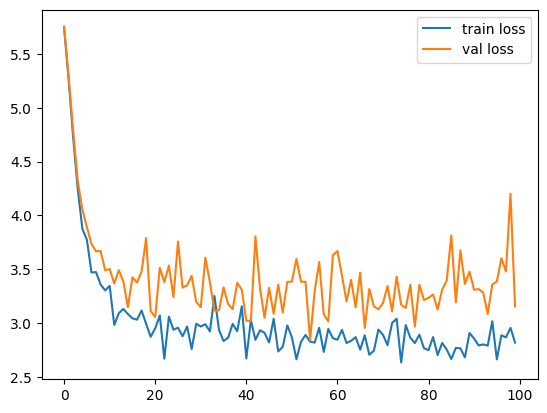

In [235]:
plt.plot(train_loss, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()

In [236]:
def generate(model, network_config, tokenizer, context_window=16, max_tokens=100):
    model.eval()
    idx = torch.zeros((1, context_window), dtype=torch.long).to(device)
    for _ in range(max_tokens):
        out = model(idx)
        # 只保留最后一个时间步的输出，因为我们只需要预测下一个token
        # shape: (batch_size, seq_len, vocab_size) -> (batch_size, vocab_size)
        # 取输出的最后一个时间步的预测结果
        # 输入形状: (batch_size, sequence_len, vocab_size)
        # 输出形状: (batch_size, vocab_size)
        # 例如输入是[0,0,0,...,0], 输出预测下一个token [0,0,0,...,1]
        # 我们只需要最后一个时间步的预测,即最后预测出的token
        out = out[:, -1, :]
        # 将输出转换为概率分布，使用softmax将logits转换为概率值
        probs = torch.softmax(out, dim=-1)
        # 根据概率分布随机采样下一个token的索引，num_samples=1表示只采样一个token
        idx_next = torch.multinomial(probs, num_samples=1)
        # 将新预测的token添加到idx中，用于下一次预测
        idx = torch.cat((idx, idx_next), dim=-1)
    return tokenizer.decode(idx.squeeze().tolist())

print(generate(model, network_config, tokenizer))

                 and to er. Weey—“ing it!’t yousom_).—ys bedenshere fwas aing HOBs h nis, Farchene
burneralf I kinto ht you—T.

IAuries m. NE


RMSNorm part

In [26]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps, partial=-1):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(dim))
        self.eps = eps
        self.partial = partial

    def forward(self, x):
        origin_shape = x.shape
        x = x.view(-1, x.shape[-1])
        if 1 >= self.partial > 0:
            partial_size = int(self.partial * x.shape[-1])
            mask = torch.rand(x.shape[-1]) < self.partial # random select index
            x_partial = x[:, mask] # select partial index
            rms = torch.sqrt(x_partial.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        else:
            rms = torch.sqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        
        x_normalized = x / rms
        x_scaled = x_normalized * self.scale
        return x_scaled.view(origin_shape)


In [238]:
class MLP_rms(nn.Module):
    def __init__(self, network_config, vocab_size, embed_dim):
        super().__init__()
        self.network_config = network_config
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)
        self.rms = RMSNorm(self.embed_dim, eps=1e-5)
        self.linear = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_dim),
            nn.ReLU(),
            nn.Linear(self.embed_dim, self.vocab_size)
        )
        print(f"#params: {sum(p.numel() for p in self.parameters())}")

    def forward(self, x, target=None):
        x = self.embedding(x)
        x = self.rms(x)
        logits = self.linear(x)
        if target is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.shape[-1]), target.view(-1))
            return logits, loss
        return logits


In [239]:
model = MLP_rms(network_config, tokenizer.vocab_size, 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_loss, val_loss = train(model, optimizer, network_config, epoch=10000, verbose=False)

#params: 93740
train time: 47.326342821121216
train loss: 2.8428378105163574


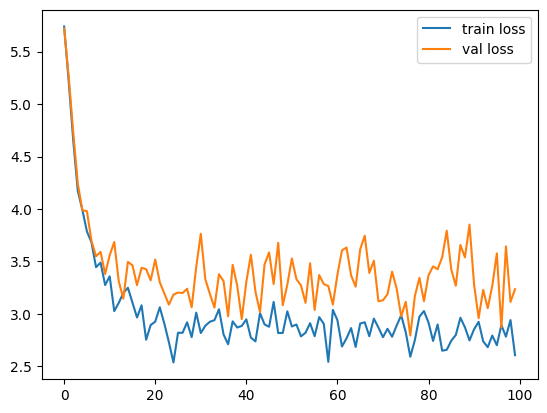

In [240]:
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.show()


RoPE part

In [19]:
class RoPE(nn.Module):
    def __init__(self, dim, base=10000):
        super().__init__()
        self.dim = dim
        self.base = base
        inv_freq = 1.0 / (base**(torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)

    def forward(self, x):
    # x: [batch_size, num_heads, seq_len, head_dim]
    # head_dim 必须是偶数
    # 1. 计算旋转所需的角度（只算一半的维度）
    #    假设 inv_freq 的形状是 [head_dim/2]
        seq_len = x.shape[2]
        pos = torch.arange(seq_len, device=x.device)                 # [seq_len]
        angles = pos[:, None] * self.inv_freq[None, :]               # [seq_len, head_dim/2]

        # 2. 得到对应的 sin, cos，并加上 batch/head 维做广播
        sin = angles.sin()[None, None, :, :]  # [1,1,seq_len,head_dim/2]
        cos = angles.cos()[None, None, :, :]

        # 3. 将输入拆成两部分，分别乘以 cos 和 sin 来做旋转
        x1, x2 = x.chunk(2, dim=-1)  # x1,x2: [batch_size, num_heads, seq_len, head_dim/2]
        out = torch.cat([x1*cos - x2*sin, x2*cos + x1*sin], dim=-1)  # [batch_size, num_heads, seq_len, head_dim]

        return out


In [20]:
rope = RoPE(128, base=1000).to(device)
x = torch.randn(1, 8, 16, 128).to(device)
x_rot = rope(x)
print(x_rot.shape)

torch.Size([1, 8, 16, 128])


In [27]:
import math
class RoPeMultiHeadAttention(nn.Module):
    def __init__(self, network_config, embed_dim, num_heads):
        super().__init__()
        self.network_config = network_config
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim
        self.wq = nn.Linear(embed_dim, embed_dim)
        self.wk = nn.Linear(embed_dim, embed_dim)
        self.wv = nn.Linear(embed_dim, embed_dim)
        self.wo = nn.Linear(embed_dim, embed_dim)
        self.rope = RoPE(self.head_dim, base=10000)

    def get_causal_mask(self, seq_len, device):
        mask = torch.ones((seq_len, seq_len), device=device).tril()
        mask = mask.log()
        return mask
        
    def forward(self, x):
        B, T, C = x.shape
        
        # 线性变换并分头
        q = self.wq(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.wk(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.wv(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        
        # 应用RoPE编码
        q = self.rope(q)
        k = self.rope(k)
        
        # 计算注意力分数
        scale = 1.0 / math.sqrt(self.head_dim)
        attn = torch.matmul(q, k.transpose(-2, -1)) * scale  # [B, nh, T, T]
        
        # 应用因果掩码
        causal_mask = self.get_causal_mask(T, x.device)
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)  # [1, 1, T, T]
        
        # 将掩码加到注意力分数上（不使用masked_fill）
        attn = attn + causal_mask
        
        # 应用softmax
        attn = F.softmax(attn, dim=-1)
        
        # 计算输出
        out = torch.matmul(attn, v)  # [B, nh, T, T] x [B, nh, T, hd] -> [B, nh, T, hd]
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.wo(out)
        
        return out


In [28]:
class RopeModel(nn.Module):
    def __init__(self, network_config, vocab_size, embed_dim, num_heads):
        super().__init__()
        self.network_config = network_config
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.mha = RoPeMultiHeadAttention(network_config, embed_dim, num_heads)
        self.rms1 = RMSNorm(embed_dim, eps=1e-5)
        self.rms2 = RMSNorm(embed_dim, eps=1e-5)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU()
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size)
        print(f"#params: {sum(p.numel() for p in self.parameters())}")
    def forward(self, x, target=None):
        x = self.embedding(x)
        x = self.rms1(x)
        x = x + self.mha(x)
        x = self.rms2(x)
        x = x + self.linear(x)
        logits = self.lm_head(x)
        if target is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), target.view(-1))
            return logits, loss
        return logits


In [29]:
model = Llamablock(network_config, tokenizer.vocab_size, 128, 8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_loss, val_loss = train(model, optimizer, network_config, epoch=10000, verbose=True)
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.show()


#params: 159916


NameError: name 'train' is not defined

SwiGLU Part

In [30]:
class SwiGLU(nn.Module):
    def __init__(self, in_features, hidden_features):
        super().__init__()
        hidden_features = hidden_features or in_features * 2
        self.w1 = nn.Linear(in_features, hidden_features)
        self.w2 = nn.Linear(in_features, hidden_features)
        self.proj = nn.Linear(hidden_features, in_features)

    def forward(self, x):
        gate = self.w1(x)
        value = self.w2(x)
        gate_activated = F.silu(gate)
        gate_value = gate_activated * value
        return self.proj(gate_value)


In [31]:
class RopeModel(nn.Module):
    def __init__(self, network_config, vocab_size, embed_dim, num_heads):
        super().__init__()
        self.network_config = network_config
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.mha = RoPeMultiHeadAttention(network_config, embed_dim, num_heads)
        self.rms1 = RMSNorm(embed_dim, eps=1e-5)
        self.rms2 = RMSNorm(embed_dim, eps=1e-5)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            SwiGLU(embed_dim, embed_dim * 4) # change relu to swiglu
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size)
        print(f"#params: {sum(p.numel() for p in self.parameters())}")
    def forward(self, x, target=None):
        x = self.embedding(x)
        x = self.rms1(x)
        x = x + self.mha(x)
        x = self.rms2(x)
        x = x + self.linear(x)
        logits = self.lm_head(x)
        if target is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), target.view(-1))
            return logits, loss
        return logits


In [ ]:
model = RopeModel(network_config, tokenizer.vocab_size, 128, 8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_loss, val_loss = train(model, optimizer, network_config, epoch=10000, verbose=True)
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.show()


#params: 357676


NameError: name 'train' is not defined

In [249]:
class LlamaBlock(nn.Module):
    def __init__(self, network_config, embed_dim, num_heads):
        super().__init__()
        self.network_config = network_config
        self.rms1 = RMSNorm(embed_dim, eps=1e-5)
        self.mha = RoPeMultiHeadAttention(network_config, embed_dim, num_heads)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            SwiGLU(embed_dim*2, embed_dim * 4),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        self.rms2 = RMSNorm(embed_dim, eps=1e-5)
        print(f"#params: {sum(p.numel() for p in self.parameters())}")
    def forward(self, x):
        x = self.rms1(x)
        x = x + self.mha(x)
        x = self.rms2(x)
        x = x + self.feedforward(x)
        return x


In [250]:
# test model
block = LlamaBlock(network_config, 128, 8).to(device)
x = torch.randn(1, 16, 128).to(device)
out = block(x)
print(out.shape)


#params: 526720
torch.Size([1, 16, 128])


In [251]:
from collections import OrderedDict
class Llama(nn.Module):
    def __init__(self, network_config, vocab_size, embed_dim, num_heads, num_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.llama_blocks = nn.Sequential(
            OrderedDict([
                (f"llama_{i}", LlamaBlock(network_config, embed_dim, num_heads)) for i in range(num_layers)])
        )
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            SwiGLU(embed_dim, embed_dim * 4),
            nn.Linear(embed_dim, embed_dim)
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size)
        print(f"#params: {sum(p.numel() for p in self.parameters())}")
    def forward(self, x, target=None):
        x = self.embeddings(x)
        x = self.llama_blocks(x)
        x = self.ffn(x)
        logits = self.lm_head(x)
        if target is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), target.view(-1))
            return logits, loss
        return logits


In [252]:
llama = Llama(network_config, tokenizer.vocab_size, 128, 8, 8).to(device)

#params: 526720
#params: 526720
#params: 526720
#params: 526720
#params: 526720
#params: 526720
#params: 526720
#params: 526720
#params: 4521644


epoch 0 loss: 5.701200485229492
val loss: 5.708914756774902


epoch 100 loss: 5.686168670654297
val loss: 5.679950714111328
epoch 200 loss: 5.410778999328613
val loss: 5.408322334289551
epoch 300 loss: 4.397401332855225
val loss: 4.7271199226379395
epoch 400 loss: 4.2632575035095215
val loss: 4.503233432769775
epoch 500 loss: 4.277907371520996
val loss: 4.210705280303955
epoch 600 loss: 3.7614493370056152
val loss: 4.015998840332031
epoch 700 loss: 3.8014626502990723
val loss: 4.033496379852295
epoch 800 loss: 3.6706621646881104
val loss: 3.8445723056793213
epoch 900 loss: 3.671827554702759
val loss: 3.804596424102783
epoch 1000 loss: 3.679058074951172
val loss: 3.68422269821167
epoch 1100 loss: 3.406324625015259
val loss: 3.699472427368164
epoch 1200 loss: 3.319335699081421
val loss: 3.8318545818328857
epoch 1300 loss: 3.397737741470337
val loss: 3.7272756099700928
epoch 1400 loss: 3.484365224838257
val loss: 3.710505962371826
epoch 1500 loss: 3.2257540225982666
val loss: 3.5425119400024414
epoch 1600 loss: 3.4927406311035156
val loss: 3.9890275

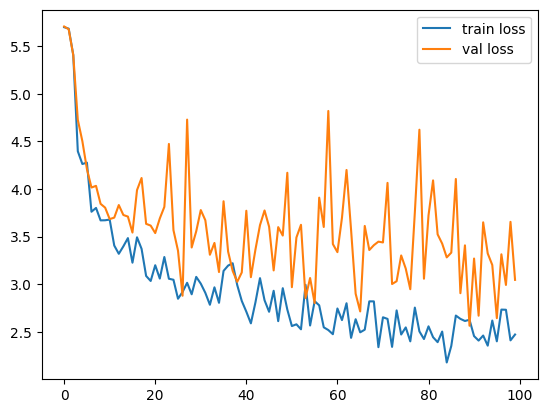

In [253]:
optimizer = torch.optim.Adam(llama.parameters(), lr=1e-5)
train_loss, val_loss = train(llama, optimizer, network_config, epoch=10000, verbose=True)
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.show()

In [254]:
print(generate(llama, network_config, tokenizer))

                Mt lig for a goof t! had you to Saver ta—thent—A.

Asive stiligher I wmd acom!

  [_RIt in tof and to way.

Mre cace youre ly I ta


In [255]:
xs, ys = get_batch(dataset, **network_config, split="test")
logits, loss = llama(xs, ys)
print(loss)

tensor(5.0563, device='cuda:0', grad_fn=<NllLossBackward0>)
